# Bayesian Networks with Continuous Variables

Our examples of Bayesian networks have so far been limited to networks of variables that are finite-valued, or discrete. It is very common for problems of interest to contain random variables that are not discrete, but are continuous, and are thus described not by a table of probabilities but by a probability density function, or PDF.

This creates a technical issue for us: we know very well how to multiply probability tables together, although this can become a formidable exercise in combinatorics. With continuous PDFs, we do not, in general know how to do this very easily (and sometime it is not possible at all. Approximate sampling is the only way we have of being able to calculate distributions.

In continuous Bayesian networks, we want to deduce the probability distribution of some continuous random variable (or variables) that depends on some other random variables, just as we are in the discrete case. In the discrete case, we work with conditional distributions and we do the same in the continuous case. Consider the following very simple example:

* A random variable $Y$ is known to be sampled from a normal distribution the mean of which is twice some other quantity $X$ and which has standard deviation $\sigma_Y$.
* $X$ is itself a random variable and is sampled from a normal distribution with mean $\mu_X$ and standard deviation $\sigma_X.

Using the notation $\mathcal{N})(Z\vert \mu,\sigma)$ to denote a normally distributed random variable of mean $\mu$ and variance $\sigma^2$, we can write:

* The PDF of $X$ is therefore $P(X) = \mathcal{N}(X\vert \mu_X,\sigma_X)$
* The PDF of $Y$ is conditioned on $X$ and $P(Y\vert X, \sigma_Y)=\mathcal{N}(Y\vert 2X,\sigma_Y)$

The question is, how does the distribution of $X$ affect the distribution of $Y$? We do not yet have tools to answer this. Let us explore.

PyMC supports continuous random variables. Let us build a model.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Z]
>Metropolis: [Y]


Output()

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'Z'}>, <Axes: title={'center': 'Z'}>],
       [<Axes: title={'center': 'Y'}>, <Axes: title={'center': 'Y'}>],
       [<Axes: title={'center': 'YY'}>, <Axes: title={'center': 'YY'}>]],
      dtype=object)

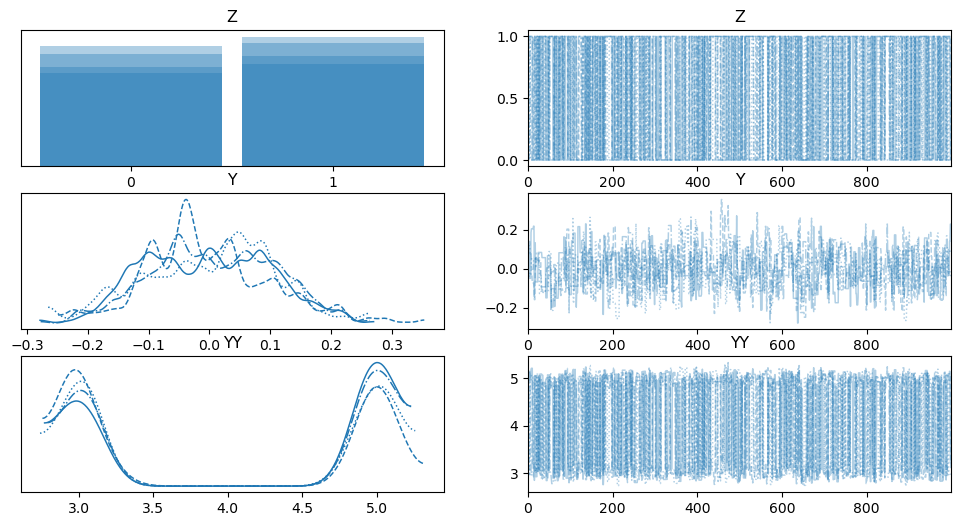

In [1]:
import pymc as mc
with mc.Model() as model:
    
    #X = mc.Normal('X', mu=5.0, sigma=1.0)
    Z = mc.Bernoulli('Z',0.5)
    Y = mc.Normal('Y', mu=0.0, sigma=0.1)
    YY = mc.Deterministic('YY', Y+2*Z+3)

    # YY = mc.Deterministic('YY', Y+mc.math.switch(Z,3.0,5.0))

    step = mc.Metropolis()
    trace = mc.sample(1000, step=step, tune=5000, random_seed=123, progressbar=True)

mc.plot_trace(trace)

## Making Decisions with Bayesian Networks

You are the manager of a store that sells coats and umbrellas. Your sales data indicates that people's buying habits have a pattern:

* They buy an umbrella when the weekly rainfall exceeds 10 (arbitrary units).
* The but a coat when the weekly rainfall exceeds 5 a.u. or the weekly temperature drops below 12 a.u.

You would to predict the likelihood of an individual buying coats or umbrellas by season to have better control of your stock numbers so you decide to build a Bayesian network based on historic weather data to help you do this. The data tells your the following.

* There are four Seasons, each of equal length.
* The amount of weekly rainfall and the daily temperature depend on the seasons.
* It is assumed that temperature and rainfall are normally distributed and that the parameters take the following values:

|     | Spring | Summer | Autumn | Winter |
|:---:|:---:|:---:|:---:|:---:|
| $\mu_R$    | 12.0 | 10.0 | 15.0 | 20.0 |
| $\sigma_R$ | 4.0 | 2.0 | 5.0 | 3.0 |
| $\mu_T$    | 15.0 | 20.0 | 10.0 | 5.0 |
| $\sigma_T$ | 3.0 | 5.0 | 5.0 | 3.0 |



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Season]
>Metropolis: [Rainbase]
>Metropolis: [Tempbase]


Output()

Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'Season'}>,
        <Axes: title={'center': 'Season'}>],
       [<Axes: title={'center': 'Rainbase'}>,
        <Axes: title={'center': 'Rainbase'}>],
       [<Axes: title={'center': 'Tempbase'}>,
        <Axes: title={'center': 'Tempbase'}>],
       [<Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Rainfall'}>],
       [<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Temperature'}>],
       [<Axes: title={'center': 'Umbrella'}>,
        <Axes: title={'center': 'Umbrella'}>],
       [<Axes: title={'center': 'Coat'}>,
        <Axes: title={'center': 'Coat'}>]], dtype=object)

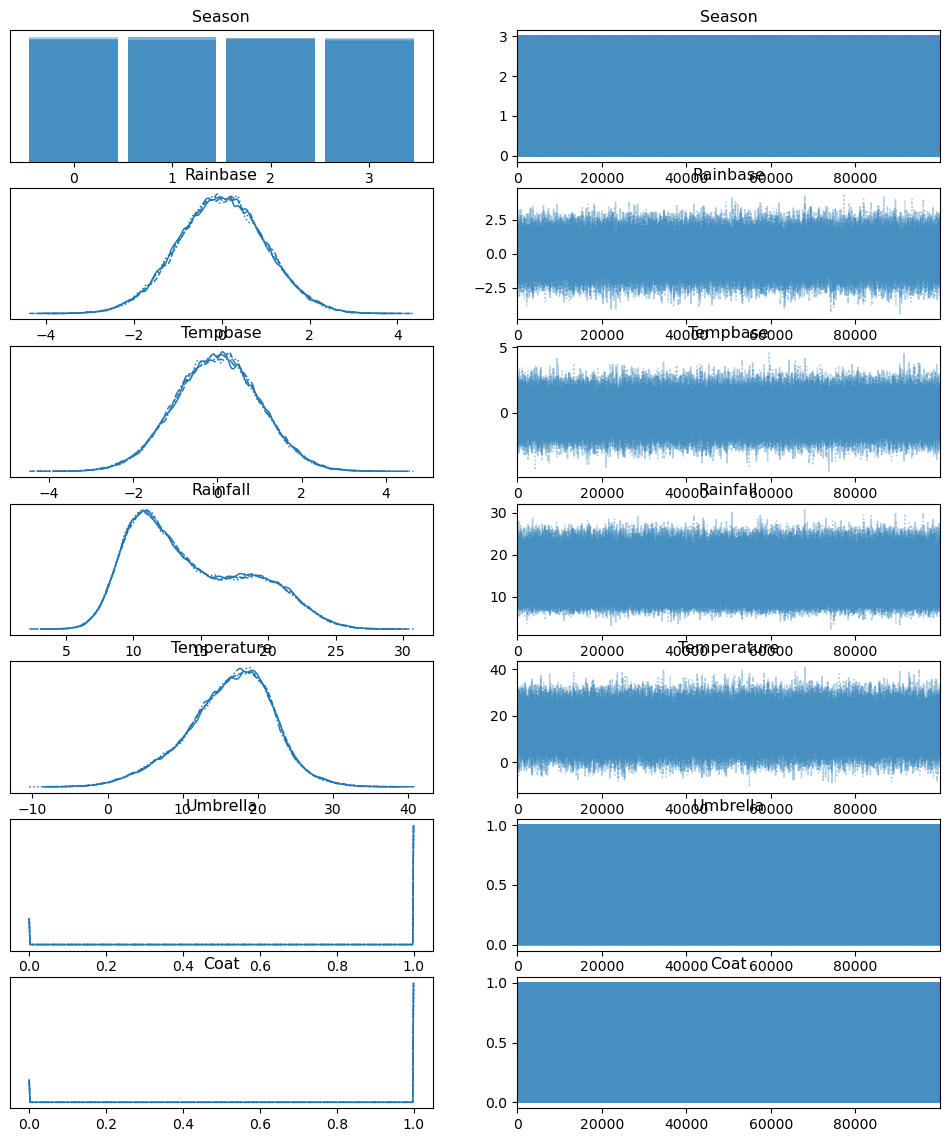

In [6]:
import numpy as np
with mc.Model() as model:
    # Define the seasons as a categorical variable
    S = mc.Categorical('Season', np.array([0.25,0.25,0.25,0.25]))
    # Create a base distribution for rainfall
    Rbase = mc.Normal('Rainbase', mu=0.0, sigma=1.0)
    Tbase = mc.Normal('Tempbase', mu=0.0, sigma=1.0)

    
    R_mu = mc.math.switch(mc.math.eq(S,0), 12.0,
                mc.math.switch(mc.math.eq(S,1), 10.0,
                    mc.math.switch(mc.math.eq(S,2), 15.0,
                        mc.math.switch(mc.math.eq(S,3), 20.0, 0.0)
                    ) 
                )
            )
    R_sigma = mc.math.switch(mc.math.eq(S,0), 2.0,
                mc.math.switch(mc.math.eq(S,1), 1.5,
                    mc.math.switch(mc.math.eq(S,2), 3.0,
                        mc.math.switch(mc.math.eq(S,3), 2.5, 0.0)
                    )
                )
            )
            
    T_mu = mc.math.switch(mc.math.eq(S,0), 15.0,
                mc.math.switch(mc.math.eq(S,1), 20.0,
                    mc.math.switch(mc.math.eq(S,2), 10.0,
                        mc.math.switch(mc.math.eq(S,3), 20.0, 5.0)
                    ) 
                )
            )
    T_sigma = mc.math.switch(mc.math.eq(S,0), 3.0,
                mc.math.switch(mc.math.eq(S,1), 5.0,
                    mc.math.switch(mc.math.eq(S,2), 5.0,
                        mc.math.switch(mc.math.eq(S,3), 2.5, 3.0)
                    )
                )
            )

    R = mc.Deterministic('Rainfall', Rbase*R_sigma + R_mu)
    T = mc.Deterministic('Temperature', Tbase*T_sigma + T_mu)
    U = mc.Deterministic('Umbrella', mc.math.switch(mc.math.ge(R,10),1.0 ,0.0))
    C = mc.Deterministic('Coat', mc.math.switch(mc.math.ge(R,10.), 1.0, mc.math.switch(mc.math.lt(T,12.), 1.0, 0.0)))

    step = mc.Metropolis()
    trace = mc.sample(100000, step=step, tune=5000, random_seed=123, progressbar=True)

mc.plot_trace(trace)

In [8]:
df=trace.to_dataframe(groups='posterior')

In [14]:
Seasons = ['Spring','Summer','Autumn','Winter']
for i,s in enumerate(Seasons):
    P_Umbrella = float(df[(df['Season'] == i) & (df['Umbrella'] ==1)].shape[0]) / df[df['Season'] == i].shape[0]
    P_Coat = float(df[(df['Season'] == i) & (df['Coat'] ==1)].shape[0]) / df[df['Season'] == i].shape[0]
    print(f"P(Umbrella|{s}) = {P_Umbrella}")
    print(f"P(Coat|{s}) = {P_Coat}")

P(Umbrella|Spring) = 0.8402858169334557
P(Coat|Spring) = 0.8659434753103669
P(Umbrella|Summer) = 0.4981103854016054
P(Coat|Summer) = 0.5245051602931645
P(Umbrella|Autumn) = 0.9535800546938938
P(Coat|Autumn) = 0.9833922190949558
P(Umbrella|Winter) = 0.9999496561515149
P(Coat|Winter) = 0.9999496561515149
